In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torch.utils.data as Data
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import *
import numpy as np
import pickle
import argparse
import pandas as pd
#from ranking import *
from sklearn.preprocessing import StandardScaler
import tqdm
import fastai
import time
import copy
import matplotlib.pyplot as plt
import itertools
import random
import os

In [2]:
def convert_dataframe_to_multi_col(representation_dataframe):
    entry = pd.DataFrame(representation_dataframe['Entry'])
    vector = pd.DataFrame(list(representation_dataframe['Vector']))
    multi_col_representation_vector = pd.merge(left=entry,right=vector,left_index=True, right_index=True)
    return multi_col_representation_vector

In [3]:
def convert_to_two_col(multi_col_representation_df):
    vals = multi_col_representation_df.iloc[:,1:(len(multi_col_representation_df.columns))]
    original_values_as_df = pd.DataFrame(columns=['Entry', 'Vector'])
    for index, row in tqdm.tqdm(vals.iterrows(), total = len(vals)):
        list_of_floats = [float(item) for item in list(row)]
        original_values_as_df.loc[index] = [multi_col_representation_df.iloc[index]['Entry']] + [list_of_floats]
    return original_values_as_df

In [4]:
seq_rep_multi_col = pd.read_csv("/media/DATA/serbulent/DATA/Thesis/ReviewPaper/generalized_representation_benchmark/DATA/representation_vectors/revision-1/T5_UNIPROT_HUMAN.csv")

In [5]:
#ppi_rep_multi_col = pd.read_csv("/media/DATA/serbulent/DATA/Thesis/TheRepresentation/PPI-Reps/Node2Vec/d_10_p_2_q_2.csv")

In [6]:
ppi_rep_multi_col = pd.read_csv("/media/DATA/serbulent/DATA/Thesis/TheRepresentation/PPI-Reps/Node2Vec/d_10_p_2_q_2.csv")

In [7]:
text_rep_multi_col =  pd.read_csv("/media/DATA/serbulent/DATA/Thesis/TheRepresentation/ProtText/representation_vectors/unipubmed_tfidf_vectors_pca1024_multi_col_vec.csv")

In [8]:
scaler = StandardScaler()

In [9]:
seq_rep_multi_col.loc[:, seq_rep_multi_col.columns != 'Entry'] = \
scaler.fit_transform(seq_rep_multi_col.loc[:, seq_rep_multi_col.columns != 'Entry'])

ppi_rep_multi_col.loc[:, ppi_rep_multi_col.columns != 'Entry'] = \
scaler.fit_transform(ppi_rep_multi_col.loc[:, ppi_rep_multi_col.columns != 'Entry'])

text_rep_multi_col.loc[:, text_rep_multi_col.columns != 'Entry'] = \
scaler.fit_transform(text_rep_multi_col.loc[:, text_rep_multi_col.columns != 'Entry'])

In [11]:
sequence_rep = convert_to_two_col(seq_rep_multi_col)

100%|██████████| 19996/19996 [00:43<00:00, 460.83it/s]


In [12]:
ppi_rep = convert_to_two_col(ppi_rep_multi_col)

100%|██████████| 16435/16435 [00:27<00:00, 599.11it/s]


In [13]:
text_rep = convert_to_two_col(text_rep_multi_col)

100%|██████████| 20301/20301 [00:44<00:00, 453.95it/s]


In [14]:
fuse_phase_1 = sequence_rep.merge(ppi_rep, on='Entry')

In [15]:
fuse_phase_2 = fuse_phase_1.merge(text_rep, on='Entry')

In [16]:
fuse_phase_2.columns = ["Entry","sequence", "ppi","text"]

In [17]:
sequence_tensors = torch.tensor(list(fuse_phase_2['sequence'].values))
ppi_tensors = torch.tensor(list(fuse_phase_2['ppi'].values))
text_tensors = torch.tensor(list(fuse_phase_2['text'].values))

In [20]:
sequence_tensors.size(1)

1024

In [16]:
batch_size = 128
validation_split = .2
shuffle_dataset = True
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [17]:
# Creating data indices for training and validation splits:
dataset_size = len(sequence_tensors)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_loader = DataLoader(train_indices, batch_size=batch_size, 
                                            pin_memory=True,shuffle=True)
validation_loader = DataLoader(val_indices, batch_size=batch_size,
                                                 pin_memory=True,shuffle=True)


# Define Model

In [18]:
representation_dim = 512

In [19]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.text_dim = 1024
        self.text_dim1 = 768
        self.text_dim2 = 512
        self.ppi_dim = 10
        self.ppi_dim1 = 10
        self.ppi_dim2 = 10
        self.seq_dim = 1024
        self.seq_dim1 = 768
        self.seq_dim2 = 512
        self.zdim = representation_dim

        self.encoder1 = nn.Sequential(
            nn.Linear(self.text_dim, self.text_dim1),
            nn.Tanh(),
            nn.Linear(self.text_dim1, self.text_dim2),
            nn.Tanh()
        )
        self.encoder2 = nn.Sequential(
            nn.Linear(self.ppi_dim, self.ppi_dim1),
            nn.Tanh(),
            nn.Linear(self.ppi_dim1, self.ppi_dim2),
            nn.Tanh()
        )
        self.encoder3 = nn.Sequential(
            nn.Linear(self.seq_dim, self.seq_dim1),
            nn.Tanh(),
            nn.Linear(self.seq_dim1, self.seq_dim2),
            nn.Tanh()
        )
        self.encoder4 = nn.Sequential(
            nn.Linear(self.text_dim2 + self.ppi_dim2 + self.seq_dim2, self.zdim),
            nn.Tanh()
        )

        self.decoder4 = nn.Sequential(
            nn.Linear(self.zdim, self.text_dim2 + self.ppi_dim2 + self.seq_dim2),
            nn.Tanh()
        )

        self.decoder3 = nn.Sequential(
            nn.Linear(self.text_dim2, self.text_dim1),
            nn.Tanh(),
            nn.Linear(self.text_dim1, self.text_dim),
            nn.Tanh()
        )
        self.decoder2 = nn.Sequential(
            nn.Linear(self.ppi_dim2, self.ppi_dim1),
            nn.Tanh(),
            nn.Linear(self.ppi_dim1, self.ppi_dim),
            nn.Tanh()
        )
        self.decoder1 = nn.Sequential(
            nn.Linear(self.seq_dim2, self.seq_dim1),
            nn.Tanh(),
            nn.Linear(self.seq_dim1, self.seq_dim),
            nn.Tanh()
        ) 
        
    def forward(self, x_text, x_ppi, x_seq):
        encoded_text = self.encoder1(x_text)
        encoded_ppi = self.encoder2(x_ppi)
        encoded_seq = self.encoder3(x_seq)
        encoded_mid = self.encoder4(torch.cat((encoded_text, encoded_ppi, encoded_seq), dim=1))
        decoded_mid = self.decoder4(encoded_mid)
        decoded_text = self.decoder3(decoded_mid[:, 0:self.text_dim2])
        decoded_ppi = self.decoder2(decoded_mid[:, self.text_dim2:self.text_dim2 + self.ppi_dim2])
        decoded_seq = self.decoder1(decoded_mid[:, self.text_dim2 + self.ppi_dim2:])
        return decoded_text, decoded_ppi, decoded_seq, encoded_mid

In [20]:
sequence_tensors[0:64].view(-1, sequence_tensors.shape[1]).to('cuda').shape

torch.Size([64, 1024])

In [21]:
def train_model(model, train_loader, validation_loader, criterion,optimizer, num_epochs,\
                sequence_tensors,text_tensors,ppi_tensors):
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10**10
    
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True)
    #scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=10, epochs=10,anneal_strategy='linear')
    #scheduler =torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=1e-8, last_epoch=-1,verbose=True)
     #scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="triangular2")
    loss_vals = []
    encoded_mid = None
    sequence_tensors_size = sequence_tensors.shape[1]
    ppi_tensors_size = ppi_tensors.shape[1]
    text_tensors_size = text_tensors.shape[1]
    for epoch in tqdm.tqdm(range(num_epochs)):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                inputs = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                inputs = validation_loader

            loss = 0
            for batch_features in inputs:
               
                # reshape mini-batch data to [N, 784] matrix
                # load it to the active device
                sequence_batch = sequence_tensors[batch_features].view(-1, sequence_tensors_size).to(device)
                ppi_batch = ppi_tensors[batch_features].view(-1, ppi_tensors_size).to(device)
                text_batch = text_tensors[batch_features].view(-1, text_tensors_size).to(device)

                # reset the gradients back to zero
                # PyTorch accumulates gradients on subsequent backward passes
                optimizer.zero_grad()
                
                decoded_text, decoded_ppi, decoded_seq, encoded_mid =\
                model(text_batch,ppi_batch,sequence_batch)

                # compute training reconstruction loss
                train_loss = criterion(decoded_text, text_batch) + \
                criterion(decoded_ppi, ppi_batch) + criterion(decoded_seq, sequence_batch) 
                #train_loss = criterion(outputs, batch_features,target)

                # compute accumulated gradients
                train_loss.backward()

                # perform parameter update based on current gradients
                optimizer.step()

                # add the mini-batch training loss to epoch loss
                loss += train_loss.item()

            # compute the epoch training loss
            epoch_loss = loss / len(inputs)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                scheduler.step(epoch_loss)
            elif phase == 'train':
                train_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history,val_loss_history,loss_vals

In [22]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [23]:
epochs = 400
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()
#criterion = nn.CosineEmbeddingLoss()

In [24]:
best_model, train_loss_history,val_loss_history,loss_vals = train_model(model, train_loader, validation_loader, criterion, optimizer, epochs,sequence_tensors,text_tensors,ppi_tensors)

 20%|█▉        | 79/400 [01:04<04:20,  1.23it/s]

Epoch    79: reducing learning rate of group 0 to 1.0000e-04.


 32%|███▏      | 128/400 [01:44<03:40,  1.23it/s]

Epoch   128: reducing learning rate of group 0 to 1.0000e-05.


 38%|███▊      | 154/400 [02:05<03:19,  1.23it/s]

Epoch   154: reducing learning rate of group 0 to 1.0000e-06.


 41%|████▏     | 165/400 [02:15<03:53,  1.00it/s]

Epoch   165: reducing learning rate of group 0 to 1.0000e-07.


 45%|████▍     | 179/400 [02:29<03:39,  1.01it/s]

Epoch   179: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 400/400 [06:04<00:00,  1.10it/s]

Training complete in 6m 5s
Best val loss: 0.868292


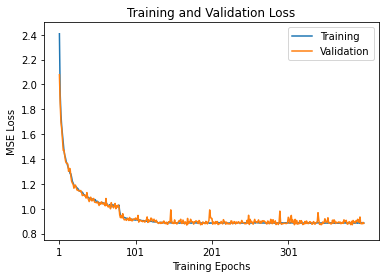

In [25]:
plt.title("Training and Validation Loss")
plt.xlabel("Training Epochs")
plt.ylabel("MSE Loss")
plt.plot(range(1,epochs+1),train_loss_history,label="Training")
plt.plot(range(1,epochs+1),val_loss_history,label="Validation")
plt.ylim((0.75,2.5))
plt.xticks(np.arange(1, epochs, 100.0))
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [26]:
# create and register an forward hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

best_model.encoder4.register_forward_hook(get_activation('encoder4'))

In [27]:
fused_rep_ae = pd.DataFrame(columns=['Entry', 'Vector'])
sequence_tensors_size = sequence_tensors.shape[1]
ppi_tensors_size = ppi_tensors.shape[1]
text_tensors_size = text_tensors.shape[1]
best_model.eval()
with torch.no_grad():
    for index,row in tqdm.tqdm(fuse_phase_2.iterrows(),total=len(fuse_phase_2)):
        #fused_rep_tensor = torch.tensor(list(row['Vector']))
        text_tensor = text_tensors[index].view(-1, text_tensors_size).to(device)
        ppi_tensor = ppi_tensors[index].view(-1, ppi_tensors_size).to(device)
        seq_tensor = sequence_tensors[index].view(-1, sequence_tensors_size).to(device)
        
        _ = best_model(text_tensor,ppi_tensor,seq_tensor)
        coding_layer_output = activation['encoder4'].tolist()[0]    
        new_row = {'Entry':row['Entry'], 'Vector':coding_layer_output}
        fused_rep_ae = fused_rep_ae.append(new_row, ignore_index=True)

100%|██████████| 16016/16016 [00:34<00:00, 463.84it/s]


In [28]:
multi_modal_rep_ae_multi_col = convert_dataframe_to_multi_col(fused_rep_ae)

In [29]:
multi_modal_rep_ae_multi_col

,Entry,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,P31946,-0.357977,0.519689,-0.226442,-0.030316,-0.504166,-0.310577,0.762578,0.775329,-0.820248,...,0.636371,-0.471406,-0.475464,-0.312855,0.368751,0.824349,0.397912,0.288390,0.176021,0.600263
1,P62258,-0.775619,0.436924,-0.211745,0.329637,-0.517471,-0.470644,0.261717,0.453064,-0.894384,...,0.720090,-0.442199,-0.679317,-0.599569,0.128913,0.617828,0.124357,0.213859,0.284625,0.229075
2,Q04917,-0.407075,0.364890,-0.430867,-0.105860,-0.119838,-0.373716,0.726596,0.764890,-0.782530,...,0.717053,-0.779265,-0.807476,-0.617518,0.294353,0.851108,0.355995,-0.030086,0.167783,0.645474
3,P61981,-0.301201,0.243369,-0.452581,-0.013414,-0.280896,-0.478758,0.672570,0.792721,-0.862385,...,0.577496,-0.518647,-0.693463,-0.529075,0.267070,0.546455,0.317777,0.422778,0.232549,0.815493
4,P31947,-0.719855,-0.330422,-0.325529,0.505221,-0.046153,-0.733239,0.822208,0.728900,-0.804104,...,0.780129,-0.790629,-0.261300,-0.374297,-0.104217,0.646351,0.091650,0.321629,0.061503,0.451217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16011,Q2QGD7,0.162932,0.156579,-0.722037,0.616376,-0.743977,-0.645961,-0.475206,-0.593877,0.578570,...,0.142718,0.580866,-0.750069,0.413171,0.789343,-0.536757,0.442986,-0.152433,0.828633,0.470770
16012,Q6WRX3,0.796820,-0.723708,0.579554,-0.470578,-0.233280,-0.283673,-0.195894,-0.362044,-0.292130,...,-0.039554,0.470316,-0.417288,-0.236481,-0.629231,-0.347806,0.010605,0.164728,-0.502808,0.178278
16013,Q9C0D3,0.775651,-0.510091,0.734860,-0.477696,0.133979,-0.394544,-0.336541,-0.808172,-0.140373,...,0.104024,-0.024060,-0.281458,-0.667646,-0.420669,-0.371359,0.069490,0.701855,-0.431050,0.002671
16014,Q15942,-0.549399,0.629996,-0.241903,-0.380937,0.684641,0.704733,0.298833,-0.913417,0.661118,...,-0.263437,0.749574,0.579274,-0.584501,0.536728,0.710438,0.341706,0.253626,-0.230799,0.368914


In [31]:
multi_modal_rep_ae_multi_col.to_csv\
("/media/DATA/serbulent/Code/Thesis/TheRepresentation/Preprocess/HoloProtRep/\
before_thesis/multi_modal_rep_ae_"+str(representation_dim)+"_dim_"+str(epochs)+"_epochs_ppi_no_comp.csv"\
,index=False)

## Define Seq Based Model

In [32]:
best_model.encoder3[0].weight.data

tensor([[ 0.0374,  0.0325, -0.0009,  ...,  0.0247,  0.0269, -0.0056],
        [-0.0069,  0.0112,  0.0289,  ..., -0.0597, -0.0193,  0.0384],
        [-0.0162,  0.0690,  0.0211,  ...,  0.0046, -0.0288,  0.0250],
        ...,
        [-0.0226, -0.0429,  0.0140,  ..., -0.0412,  0.0510, -0.0125],
        [ 0.0386, -0.0519, -0.0077,  ..., -0.0067,  0.0013,  0.0542],
        [-0.0006,  0.0065,  0.0576,  ..., -0.0291, -0.0844,  0.0321]],
       device='cuda:0')

In [33]:
len(best_model.encoder3)

4

In [34]:
class Autoencoder_Seq(nn.Module):
    def __init__(self,pretrained_model):
        super(Autoencoder_Seq, self).__init__()
        self.pretrained_model = pretrained_model
        
        self.text_dim = 1024
        self.text_dim1 = 768
        self.text_dim2 = 512
        self.ppi_dim = 10
        self.ppi_dim1 = 10
        self.ppi_dim2 = 10
        self.seq_dim = 1024
        self.seq_dim1 = 768
        self.seq_dim2 = 512
        self.zdim = representation_dim

        self.encoder3 = nn.Sequential(
            nn.Linear(self.seq_dim, self.seq_dim1),
            nn.Tanh(),
            nn.Linear(self.seq_dim1, self.seq_dim2),
            nn.Tanh()
        )
        self.encoder4 = nn.Sequential(
            nn.Linear(self.seq_dim2, self.zdim),
            nn.Tanh()
        )

        self.decoder4 = nn.Sequential(
            nn.Linear(self.zdim, self.text_dim2 + self.ppi_dim2 + self.seq_dim2),
            nn.Tanh()
        )

        self.decoder3 = nn.Sequential(
            nn.Linear(self.text_dim2, self.text_dim1),
            nn.Tanh(),
            nn.Linear(self.text_dim1, self.text_dim),
            nn.Tanh()
        )
        self.decoder2 = nn.Sequential(
            nn.Linear(self.ppi_dim2, self.ppi_dim1),
            nn.Tanh(),
            nn.Linear(self.ppi_dim1, self.ppi_dim),
            nn.Tanh()
        )
        self.decoder1 = nn.Sequential(
            nn.Linear(self.seq_dim2, self.seq_dim1),
            nn.Tanh(),
            nn.Linear(self.seq_dim1, self.seq_dim),
            nn.Tanh()
        )
        
    def load_parameters(self):
        self.encoder3[0].weight.data = copy.deepcopy(self.pretrained_model.encoder3[0].weight.data)
        self.encoder3[2].weight.data = copy.deepcopy(self.pretrained_model.encoder3[2].weight.data)
        self.encoder3[0].bias.data = copy.deepcopy(self.pretrained_model.encoder3[0].bias.data)
        self.encoder3[2].bias.data = copy.deepcopy(self.pretrained_model.encoder3[2].bias.data)
        
        self.decoder4[0].weight.data = copy.deepcopy(self.pretrained_model.decoder4[0].weight.data)
        self.decoder4[0].bias.data = copy.deepcopy(self.pretrained_model.decoder4[0].bias.data)
        
        self.decoder3[0].weight.data = copy.deepcopy(self.pretrained_model.decoder3[0].weight.data)
        self.decoder3[2].weight.data = copy.deepcopy(self.pretrained_model.decoder3[2].weight.data)
        self.decoder3[0].bias.data = copy.deepcopy(self.pretrained_model.decoder3[0].bias.data)
        self.decoder3[2].bias.data = copy.deepcopy(self.pretrained_model.decoder3[2].bias.data)
        
        self.decoder2[0].weight.data = copy.deepcopy(self.pretrained_model.decoder2[0].weight.data)
        self.decoder2[2].weight.data = copy.deepcopy(self.pretrained_model.decoder2[2].weight.data)
        self.decoder2[0].bias.data = copy.deepcopy(self.pretrained_model.decoder2[0].bias.data)
        self.decoder2[2].bias.data = copy.deepcopy(self.pretrained_model.decoder2[2].bias.data)
        
        self.decoder1[0].weight.data = copy.deepcopy(self.pretrained_model.decoder1[0].weight.data)
        self.decoder1[2].weight.data = copy.deepcopy(self.pretrained_model.decoder1[2].weight.data)
        self.decoder1[0].bias.data = copy.deepcopy(self.pretrained_model.decoder1[0].bias.data)
        self.decoder1[2].bias.data = copy.deepcopy(self.pretrained_model.decoder1[2].bias.data)

    def forward(self, x_seq):
        encoded_seq = self.encoder3(x_seq)
        encoded_mid = self.encoder4(encoded_seq)
        decoded_mid = self.decoder4(encoded_mid)
        decoded_text = self.decoder3(decoded_mid[:, 0:self.text_dim2])
        decoded_ppi = self.decoder2(decoded_mid[:, self.text_dim2:self.text_dim2 + self.ppi_dim2])
        decoded_seq = self.decoder1(decoded_mid[:, self.text_dim2 + self.ppi_dim2:])
        return decoded_text, decoded_ppi, decoded_seq, encoded_mid

In [35]:
def train_model_for_seq(model, train_loader, validation_loader, criterion,optimizer, num_epochs,\
                sequence_tensors,text_tensors,ppi_tensors):
    since = time.time()

    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10**10    
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True)
    loss_vals = []
    encoded_mid = None
    sequence_tensors_size = sequence_tensors.shape[1]
    ppi_tensors_size = ppi_tensors.shape[1]
    text_tensors_size = text_tensors.shape[1]
    for epoch in tqdm.tqdm(range(num_epochs)):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                inputs = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                inputs = validation_loader

            loss = 0
            for batch_features in inputs:
                sequence_batch = sequence_tensors[batch_features].view(-1, sequence_tensors_size).to(device)
                ppi_batch = ppi_tensors[batch_features].view(-1, ppi_tensors_size).to(device)
                text_batch = text_tensors[batch_features].view(-1, text_tensors_size).to(device)             
                # PyTorch accumulates gradients on subsequent backward passes
                optimizer.zero_grad()                
                decoded_text, decoded_ppi, decoded_seq, encoded_mid =\
                model(sequence_batch)
                # compute training reconstruction loss
                train_loss = criterion(decoded_text, text_batch) + \
                criterion(decoded_ppi, ppi_batch) + criterion(decoded_seq, sequence_batch) 
                #train_loss = criterion(outputs, batch_features,target)
                # compute accumulated gradients
                train_loss.backward()
                # perform parameter update based on current gradients
                optimizer.step()
                # add the mini-batch training loss to epoch loss
                loss += train_loss.item()
            # compute the epoch training loss
            epoch_loss = loss / len(inputs)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                scheduler.step(epoch_loss)
            elif phase == 'train':
                train_loss_history.append(epoch_loss)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history,val_loss_history,loss_vals

In [36]:
epochs = 500
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder_Seq(best_model).to(device)
model.load_parameters()
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()
#criterion = nn.CosineEmbeddingLoss()

In [37]:
best_model_seq, train_loss_history_seq,val_loss_history_seq,loss_vals_seq\
= train_model_for_seq(model, train_loader, validation_loader, criterion,\
              optimizer, epochs,sequence_tensors,text_tensors,ppi_tensors)

  5%|▌         | 26/500 [00:27<07:53,  1.00it/s]

Epoch    26: reducing learning rate of group 0 to 1.0000e-04.


 21%|██        | 105/500 [01:48<07:20,  1.11s/it]

Epoch   105: reducing learning rate of group 0 to 1.0000e-05.


 25%|██▌       | 127/500 [02:13<06:46,  1.09s/it]

Epoch   127: reducing learning rate of group 0 to 1.0000e-06.


 30%|██▉       | 148/500 [02:36<06:21,  1.08s/it]

Epoch   148: reducing learning rate of group 0 to 1.0000e-07.


 32%|███▏      | 159/500 [02:48<06:10,  1.09s/it]

Epoch   159: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 500/500 [08:57<00:00,  1.07s/it]

Training complete in 8m 57s
Best val loss: 1.502444


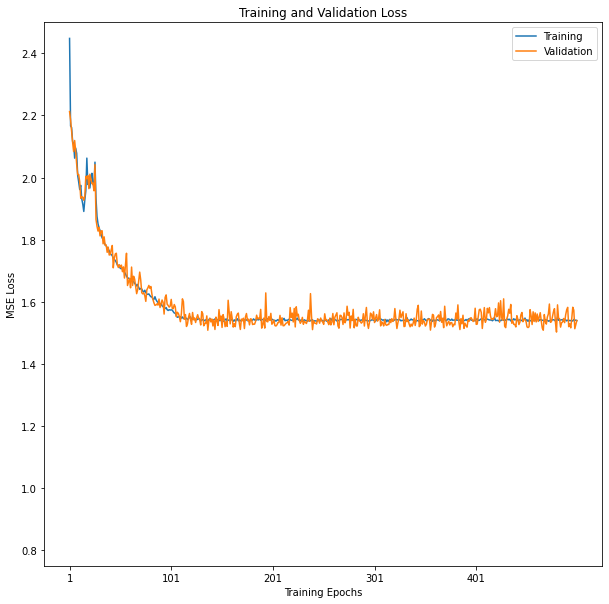

In [38]:
plt.title("Training and Validation Loss")
plt.xlabel("Training Epochs")
plt.ylabel("MSE Loss")
plt.plot(range(1,epochs+1),train_loss_history_seq,label="Training")
plt.plot(range(1,epochs+1),val_loss_history_seq,label="Validation")
plt.ylim((0.75,2.5))
plt.xticks(np.arange(1, epochs, 100.0))
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [39]:
# create and register an forward hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

best_model_seq.encoder4.register_forward_hook(get_activation('encoder4'))
#x = fused_rep_torch_tensor[0].to(device)
#best_model.eval()
#with torch.no_grad():
    #output = best_model(x)
#activation['encoded_mid'].shape

In [40]:
sequence_tensors_size = sequence_tensors.shape[1]
ppi_tensors_size = ppi_tensors.shape[1]
text_tensors_size = text_tensors.shape[1]

best_model_seq.eval()
with torch.no_grad():
    output = best_model_seq(sequence_tensors[0].view(-1, sequence_tensors_size).to(device))

In [41]:
fused_rep_ae = pd.DataFrame(columns=['Entry', 'Vector'])
#sequence_tensors_size = sequence_tensors.shape[1]
#ppi_tensors_size = ppi_tensors.shape[1]
#text_tensors_size = text_tensors.shape[1]
best_model.eval()
with torch.no_grad():
    for index,row in tqdm.tqdm(fuse_phase_2.iterrows(),total=len(fuse_phase_2)):
        #fused_rep_tensor = torch.tensor(list(row['Vector']))
        text_tensor = text_tensors[index].view(-1, text_tensors_size).to(device)
        ppi_tensor = ppi_tensors[index].view(-1, ppi_tensors_size).to(device)
        seq_tensor = sequence_tensors[index].view(-1, sequence_tensors_size).to(device)
        
        _ = best_model_seq(seq_tensor)
        coding_layer_output = activation['encoder4'].tolist()[0]    
        new_row = {'Entry':row['Entry'], 'Vector':coding_layer_output}
        fused_rep_ae = fused_rep_ae.append(new_row, ignore_index=True)

100%|██████████| 16016/16016 [00:31<00:00, 509.29it/s]


In [42]:
multi_modal_rep_ae_multi_col = convert_dataframe_to_multi_col(fused_rep_ae)

In [43]:
multi_modal_rep_ae_multi_col.to_csv\
("/media/DATA/serbulent/Code/Thesis/TheRepresentation/Preprocess/HoloProtRep/\
before_thesis/multi_modal_rep_ae_seq_based_"+str(representation_dim)+"_dim_"+str(epochs)+"_epochs_ppi_no_comp.csv"\
,index=False)